# Exampe: sphere with I22 dataset

This notebook shows how to use `ffsas` to invert for the radius distribution of a `Sphere` model with a real dataset called "I22". It uses the [SASView/SASModels](http://www.sasview.org/docs/user/models/sphere.html) unit system.

In [1]:
# avoid omp error on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# plotting setup
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'legend.fontsize': 14})
matplotlib.rcParams.update({'axes.titlesize': 14})
matplotlib.rcParams.update({'lines.linewidth': 1})
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble":  r'\usepackage{bm,upgreek}',
    "font.family": "sans-serif",
    "font.serif": ["Times"]})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# create output dir
from pathlib import Path
paper_fig_dir = Path('./output/paper_fig')
Path(paper_fig_dir).mkdir(parents=True, exist_ok=True)

In [2]:
# uncomment this line to install ffsas
# !pip install ffsas

# ffsas
import torch
import ffsas
from ffsas.models import Sphere
from ffsas.system import SASGreensSystem

# math tools
from scipy import interpolate

# numpy for reading data
import numpy as np

# Read data

Data are stored in the text file `I22_data/observation.txt`, with the three columns being $q$, mean and standard deviation of the observed intensity.

In [3]:
# read data
fname = f'I22_data/observation.txt'
data = np.loadtxt(fname)

# q vector
q = torch.tensor(data[:, 0], dtype=ffsas.torch_dtype)

# intensity mean
mu = torch.tensor(data[:, 1], dtype=ffsas.torch_dtype)

# intensity stddev
sigma = torch.tensor(data[:, 2], dtype=ffsas.torch_dtype)

# Inversion

Just a few lines to do inversion:

In [20]:
# specify radii
r = torch.linspace(400, 1200, 1000)

# compute the Green's tensor
G = Sphere.compute_G_mini_batch([q], {'r': r}, {'drho': 1.})

# build G-system
g_sys = SASGreensSystem(G, Sphere.get_par_keys_G())

# inversion
# do 500 iterations and save every 100 iterations
results = g_sys.solve_inverse(mu, sigma, maxiter=500, save_iter=100, 
                              trust_options={'xtol': 0, 'gtol':0}, verbose=1)

<BEGIN> Computing the Green's tensor G
....<MESSG> Class name = Sphere
....<BEGIN> Checking tensor dtypes
........<MESSG> torch dtype = torch.float64
....<ENDED> Checking tensor dtypes [ELAPSED = 0.001084 sec]
....<BEGIN> Computing volume V
....<ENDED> Computing volume V [ELAPSED = 0.000220 sec]
....<BEGIN> Handling fixed parameters
........<MESSG> model parameters = ['r']
........<MESSG> fixed parameters = []
........<MESSG> free parameters = ['r']
....<ENDED> Handling fixed parameters [ELAPSED = 0.002761 sec]
....<BEGIN> Creating space for G
........<MESSG> G shape = [1024, 1000]
........<MESSG> G count = 1024000
........<MESSG> G size (MB) = 8.192
........<MESSG> G stored in memory
....<ENDED> Creating space for G [ELAPSED = 0.003282 sec]
....<BEGIN> Sending parameters and constants to device
........<MESSG> device = cpu
....<ENDED> Sending parameters and constants to device [ELAPSED = 0.002230 sec]
....<BEGIN> Creating batch indices
........<MESSG> batch size = 1024
........<MESSG>

---

# Plot results

First plot `ffsas` results at different iterations.

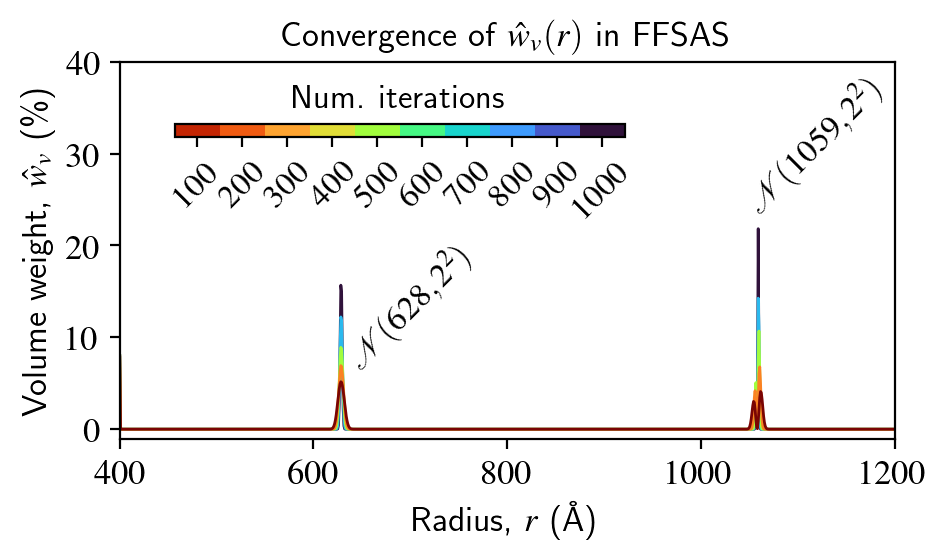

FFSAS v1/v2 = 0.58:0.42


In [56]:
# volume
v = r ** 3

# colormap
cmap = matplotlib.cm.get_cmap('turbo_r')

# steps to plot (every 100 iters)
n_results = len(results['saved_res'])
plot_steps = range(n_results)

# plot
fig=plt.figure(dpi=200, figsize=(7/1.4, 3.5/1.4))
for j, step in enumerate(plot_steps):
    w = results['saved_res'][step]['w_dict']['r']
    w_hat = w * v / (w * v).sum() * 100  # x100 to percent
    plt.plot(r, w_hat, zorder=-j, c=cmap(step / (n_results - 1)),
             label=r'$w(r)$, iters=%d, wct=%.1f sec' % 
             (results['saved_res'][step]['nit'], 
              results['saved_res'][step]['wct']))
    
plt.xlim(r.min(), r.max())
plt.ylabel(r'Volume weight, $\hat{w}_v$ (\%)')
plt.xlabel(r'Radius, $r$ (\AA)')
plt.title(r'Convergence of $\hat{w}_v(r)$ in FFSAS')


# Gaussian approximations of populations
r_ranges=[[420, 800],
          [800, 1180]]

area_all_ffsas = []
for i, (r_min, r_max) in enumerate(r_ranges):
    # find peak
    i_min = torch.argmin(torch.abs(r - r_min))
    i_max = torch.argmin(torch.abs(r - r_max))
    max_loc = torch.argmax(w_hat[i_min:i_max])
    r_top = r[i_min + max_loc]
    
    # find stddev
    area_all = torch.sum(w_hat[i_min:i_max])
    area_all_ffsas.append(area_all)
    for stddev in range(1, 50):
        area = torch.sum(w_hat[i_min + max_loc - stddev:i_min + max_loc + stddev])
        if area >= area_all * .68:
            break

    # texts
    if r_max == 800:
        plt.text(r_top - 1, w_hat[i_min + max_loc] - 2.2, 
                 r'$\mathcal{N}(%d,%d^2)$' % (round(r_top.item()), 
                                              round(stddev / len(r) * (r.max() - r.min()).item())), 
                 ha='left', va='center', fontsize=12, rotation=45)
    else:
        plt.text(r_top - 20, max(w_hat[i_min + max_loc] + 1., .7), 
                 r'$\mathcal{N}(%d,%d^2)$' % (round(r_top.item()), 
                                              round(stddev / len(r) * (r.max() - r.min()).item())), 
                 ha='left', va='bottom', fontsize=12, rotation=45)
plt.ylim(None, 40)

# legend                 
norm = matplotlib.colors.Normalize(vmin=0, vmax=1000)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbaxes = fig.add_axes([0.18, 0.73, 0.45, .025]) 
cb = plt.colorbar(sm, ticks=np.arange(100,1001,100), 
                  boundaries=np.arange(50,1101,100),
                  cax=cbaxes, orientation='horizontal')
cb.ax.tick_params(labelsize=12) 
cb.ax.set_title('Num. iterations', fontsize=12)
cb.ax.tick_params(axis='x', labelrotation = 45)
plt.show()

# volume ratio of the two populations
v1 = area_all_ffsas[0] / (area_all_ffsas[0] + area_all_ffsas[1])
print(f'FFSAS v1/v2 = {v1:.2f}:{1 - v1:.2f}')

Now compare `ffsas`, `McSAS` and `SasView` results. 

In [57]:
#### MCSAS ####
# read
data = np.loadtxt('I22_data/mcsas_w(r).dat', skiprows=1)
vol_frac_low = data[:, 2]

# convert to the same resolution
x = np.linspace(400, 1200, len(vol_frac_low))
vol_frac_high = torch.from_numpy(interpolate.interp1d(x, vol_frac_low)(r))

# Gaussian approximation
area_all_mcsas = []
for i, (r_min, r_max) in enumerate(r_ranges):
    # find peak
    i_min = torch.argmin(torch.abs(r - r_min))
    i_max = torch.argmin(torch.abs(r - r_max))
    max_loc = torch.argmax(vol_frac_high[i_min:i_max])
    r_top = r[i_min + max_loc]
    
    # find stddev
    area_all = torch.sum(vol_frac_high[i_min:i_max])
    area_all_mcsas.append(area_all)
    for stddev in range(1, 50):
        area = torch.sum(vol_frac_high[i_min + max_loc - stddev:i_min + max_loc + stddev])
        if area >= area_all * .68:
            break
    print(f'McSAS N({r_top}, {round(stddev / len(r) * (r.max() - r.min()).item())}^2)')        
    
# volume ratio of the two populations
v1 = area_all_mcsas[0] / (area_all_mcsas[0] + area_all_mcsas[1])
print(f'McSAS v1/v2 = {v1:.2f}:{1 - v1:.2f}')

#### SASView ####
# read
r_mean1, PD1, scale1, r_mean2, PD2, scale2, scale, b = np.loadtxt('I22_data/sasview_gaussian.txt', skiprows=1)
sigm1 = r_mean1 * PD1
sigm2 = r_mean2 * PD2
print(f'SasView N({r_mean1}, {sigm1}^2)')
print(f'SasView N({r_mean2}, {sigm2}^2)')
v1 = scale1 / (scale1 + scale2)
print(f'SasView v1/v2 = {v1:.2f}:{1 - v1:.2f}')

# weights
g1 = torch.exp(-.5 * ((r - r_mean1) / sigm1) ** 2)
g2 = torch.exp(-.5 * ((r - r_mean2) / sigm2) ** 2)
w_sasview = scale1 * g1 / r_mean1**3 + scale2 * g2 / r_mean2**3
w_sasview /= w_sasview.sum()
scale *= scale1 + scale2

McSAS N(625.0250250250251, 6^2)
McSAS N(1063.063063063063, 6^2)
McSAS v1/v2 = 0.58:0.42
SasView N(613.6, 0.327920112^2)
SasView N(1058.2, 0.10582000000000001^2)
SasView v1/v2 = 0.60:0.40


Finally, we compare the intensity fit. First, we compute the predicted intensities.

In [45]:
g_sys_full = g_sys

# FFSAS
I_ffsas = g_sys_full.compute_intensity(w_dict=results['w_dict'], 
                                       xi=results['xi'], b=results['b'])

# McSAS
xi_mcsas, b_mcsas = np.loadtxt('I22_data/mcsas_xi_b.txt', skiprows=1)
w_mcsas = vol_frac_high / v / (vol_frac_high / v).sum()
I_mcsas = g_sys_full.compute_intensity(w_dict={'r': w_mcsas}, xi=xi_mcsas, b=b_mcsas)

# # SasView
xi_sasview = 1e-4 * scale / (w_sasview * (4 / 3 * np.pi * r ** 3)).sum() 
I_sasview = g_sys_full.compute_intensity(w_dict={'r': w_sasview}, 
                                         xi=xi_sasview, b=b)

<ipython-input-50-1597b9e5a858>:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(paper_fig_dir / 'I22.pdf', bbox_inches='tight', facecolor='w', padding_inches=.05)


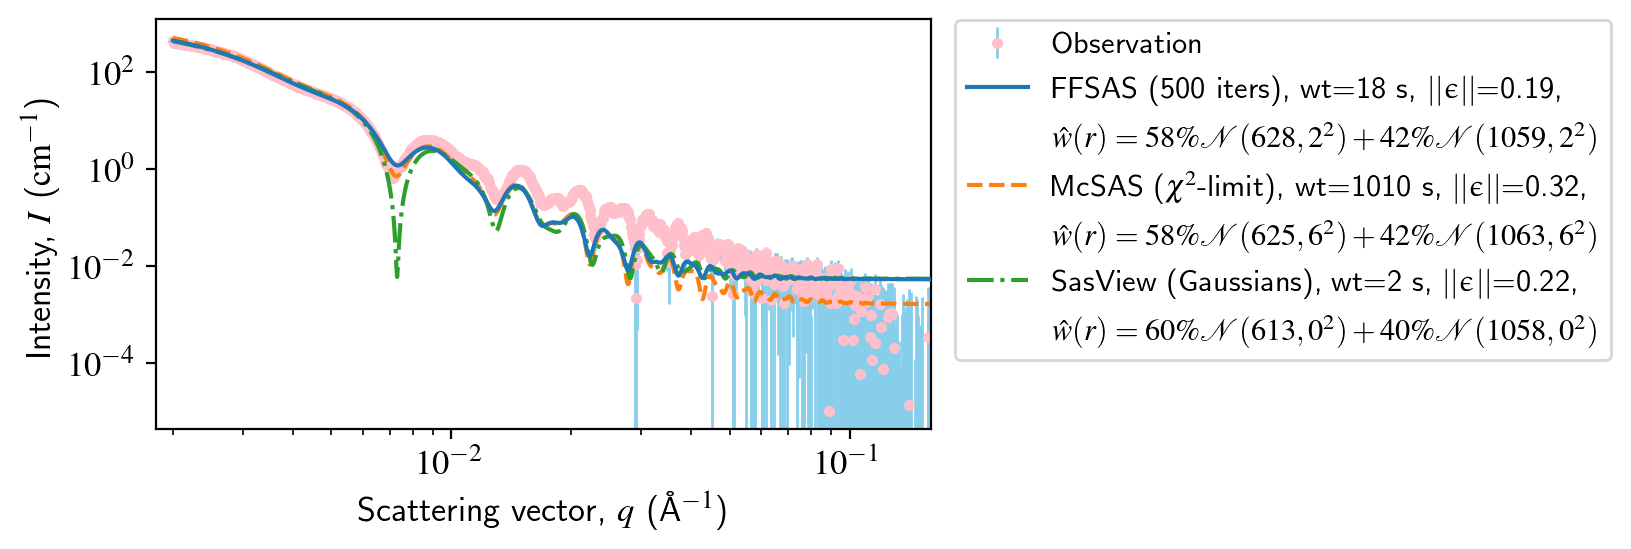

In [50]:
matplotlib.rcParams.update({'font.size': 12.5})
matplotlib.rcParams.update({'legend.fontsize': 12.5})
matplotlib.rcParams.update({'axes.titlesize': 12.5})


fig=plt.figure(dpi=200, figsize=(7/1.4, 3.8/1.4))

# data
plt.errorbar(q, mu, yerr=sigma, c='pink', ecolor='skyblue', lw=1, fmt='o',
             markersize=3, label=r'Observation', zorder=-100)

# FFSAS
I = I_ffsas
eps_norm = np.linalg.norm((mu - I) / sigma) / len(mu)
plt.plot(q, I, ls='-', lw=1.5, zorder=100,
         label=r'FFSAS (500 iters), wt=18 s, $||\bm{\upepsilon}||$=%.2f,' % (eps_norm))
plt.plot(q, I, ls='-', lw=1.5, zorder=-10000000, color='w',
         label=r'$\hat{w}(r)=58\%\mathcal{N}(628, 2^2)+42\%\mathcal{N}(1059, 2^2)$') 

    
# # McSAS
I = I_mcsas
eps_norm = np.linalg.norm((mu - I) / sigma) / len(mu)
plt.plot(q, I, ls='--', lw=1.5, zorder=0,
         label=r'McSAS ($\chi^2$-limit), wt=1010 s, $||\bm{\upepsilon}||$=%.2f,' % (eps_norm))
plt.plot(q, I, ls='--', lw=1.5, zorder=-10000000, color='w',
         label=r'$\hat{w}(r)=58\%\mathcal{N}(625, 6^2)+42\%\mathcal{N}(1063, 6^2)$')

# SASView
I = I_sasview
eps_norm = np.linalg.norm((mu - I) / sigma) / len(mu)
plt.plot(q, I, ls='-.', lw=1.5, zorder=0,
         label=r'SasView (Gaussians), wt=2 s, $||\bm{\upepsilon}||$=%.2f,' % (eps_norm))
plt.plot(q, I, ls='-.', lw=1.5, zorder=-10000000, color='w',
         label=r'$\hat{w}(r)=60\%\mathcal{N}(613, 0^2)+40\%\mathcal{N}(1058, 0^2)$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Scattering vector, $q$ (\AA$^{-1}$)')
plt.ylabel('Intensity, $I$ ($\mathrm{cm}^{-1}$)')
handles, labels = plt.gca().get_legend_handles_labels()
handles.insert(0, handles.pop())
labels.insert(0, labels.pop())
plt.legend(handles, labels, prop={'size': 11}, loc=[1.03,0.169], labelspacing=.5)
plt.xlim(q[0]/1.1, q[-50])

# save for paper
plt.savefig(paper_fig_dir / 'I22.pdf', bbox_inches='tight', facecolor='w', padding_inches=.05)
plt.show()

---